In [ ]:
#imports:
import datetime, os, csv, shutil
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten

In [ ]:
#mount G-Drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
#change the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#Download and unzip datasets:
!kaggle datasets download -d szdxfkmgnb/waste-classification
!kaggle datasets download -d arkadiyhacks/drinking-waste-classification
# Upload trashnet-dataset-resized from local 

#unzip and delete .zip files
!unzip \*.zip  && rm *.zip

In [ ]:
current_dir = os.getcwd()
print(current_dir)
labels = {'glass': 0, 'metal': 1, 'paper': 2, 'plastic':3}
directories = {'AluCan': 1, 'Glass': 0, 'HDPEM': 3, 'PET':3}
labels3 = {'cardboard': 2, 'glass': 0, 'metal': 1, 'paper':2, 'plastic' : 3}

/content/gdrive/My Drive/Kaggle


In [ ]:
#Write data to csv:
def append_list_as_row(filename, list_of_elem):
    with open(filename, 'a+', newline='') as write_obj:
        csv_writer = csv.writer(write_obj)
        csv_writer.writerow(list_of_elem)

def create_csv(directory, csv, labels):
  for list in os.listdir(directory):
    for img in os.listdir(os.path.join(directory, list)):
        img_name = os.path.basename(img)
        append_list_as_row(csv, [img_name, labels[list]])

In [ ]:
#Labels:

#Create and add header to csv files:
append_list_as_row('labels1.csv', ['id', 'class'])
append_list_as_row('labels2.csv', ['id', 'class'])
append_list_as_row('labels3.csv', ['id', 'class'])

#Define paths:
dataset1 = os.path.join(current_dir, 'dataset')
dataset2 = os.path.join(current_dir, 'Images_of_Waste/rawimgs')
dataset3 = os.path.join(current_dir, 'dataset-resized')

#Create csv files for the three datasets:
create_csv(dataset1, 'labels1.csv', labels)
create_csv(dataset2, 'labels2.csv', directories)
create_csv(dataset3, 'labels3.csv', labels3)

In [ ]:
#get data-paths:
labels_csv = pd.read_csv('labels1.csv')
img_names1 = ['labels/' + fname for fname in labels_csv['id'].tolist()]
img_labels1 = labels_csv['class'].tolist()

labels2_csv = pd.read_csv('labels2.csv')
img_names2 = ['labels/' + fname for fname in labels2_csv['id'].tolist()][1:]
img_labels2 = labels2_csv['class'].tolist()[1:]

labels3_csv = pd.read_csv('labels3.csv')
img_names3 = ['labels/' + fname for fname in labels3_csv['id'].tolist()]
img_labels3 = labels3_csv['class'].tolist()

In [ ]:
#If error:
shutil.rmtree('/content/gdrive/My Drive/Kaggle/train1') 
shutil.rmtree('/content/gdrive/My Drive/Kaggle/test1')
shutil.rmtree('/content/gdrive/My Drive/Kaggle/train2') 
shutil.rmtree('/content/gdrive/My Drive/Kaggle/test2')

In [ ]:
parent_dir = '/content/gdrive/My Drive/Kaggle'
datasets = ['1', '2', '3']

for dataset in datasets:
  os.mkdir(parent_dir + '/train' + dataset)
  os.mkdir(parent_dir + '/test' + dataset)

In [ ]:
classes = ['glass', 'metal', 'paper', 'plastic']
labels_1 = {'0': 'glass', '1' : 'metal', '2' : 'paper', '3' : 'plastic'}

#Split datasets into train and test
train_filenames1, test_filenames1, train_labels1, test_labels1 = train_test_split(img_names1, img_labels1, train_size=0.8, random_state=42)
train_filenames2, test_filenames2, train_labels2, test_labels2 = train_test_split(img_names2, img_labels2, train_size=0.8, random_state=42)
train_filenames3, test_filenames3, train_labels3, test_labels3 = train_test_split(img_names3, img_labels3, train_size=0.8, random_state=42)

#Create directories:
for dataset in datasets: 
  for item in classes:
    os.mkdir(parent_dir + '/' + 'test' + dataset + '/' + item)
    os.mkdir(parent_dir + '/' + 'train' + dataset + '/' + item)

train1_dest_dir = parent_dir + '/' + 'train1'
train2_dest_dir = parent_dir + '/' + 'train2'
train3_dest_dir = parent_dir + '/' + 'train3'
test1_dest_dir = parent_dir + '/' + 'test1'
test2_dest_dir = parent_dir + '/' + 'test2'
test3_dest_dir = parent_dir + '/' + 'test3'

In [ ]:
#Move split data to the newly created directories
def splitData(filenames, labels, dest_dir, src_dir, label_dict, names_dict=0):
  i = 0
  for item_name, label in zip(filenames, labels):
    i += 1
    print(i)
    item_name = os.path.basename(item_name)
    if names_dict == 0:
      img_type = label_dict.get(str(label))
      img_name = img_type
    else:
      img_type = ''.join([i for i in item_name if not i.isdigit()]) 
      img_type =  os.path.splitext(img_type)[0].replace(',', '')
      img_name = label_dict.get(str(label))
 
    train_path = src_dir + '/' + img_type + '/' + item_name
    shutil.copy(train_path, dest_dir + '/' + img_name)
 
splitData(train_filenames1, train_labels1, train1_dest_dir, dataset1, labels_1)
splitData(train_filenames2, train_labels2, train2_dest_dir, dataset2, labels_1, 1)
splitData(test_filenames1, test_labels1, test1_dest_dir, dataset1, labels_1)
splitData(test_filenames2, test_labels2, test2_dest_dir, dataset2, labels_1, 1)
splitData(train_filenames3, train_labels3, train3_dest_dir, dataset3, labels_1, 1)
splitData(test_filenames3, test_labels3, test3_dest_dir, dataset3, labels_1, 1)

In [ ]:
#2nd Move split data to the newly created directories
src1_path = parent_dir + '/dataset'

for item_name, label in zip(train_filenames1, train_labels1):
  img_type = labels_1.get(str(label))
  item_name = os.path.basename(item_name)
  train_path = src1_path + '/' + img_type + '/' + item_name
  shutil.copy(train_path, train1_dest_dir + '/' + img_type)
 
 
for item_name, label in zip(test_filenames1, test_labels1):
  img_type = labels_1.get(str(label))
  item_name = os.path.basename(item_name)
  test_path = src1_path + '/' + img_type + '/' + item_name
  shutil.copy(test_path, test1_dest_dir+ '/' + img_type)

In [ ]:
#Datagen for model training:
img_size = 255
batch_size = 20
 
train_datagen = ImageDataGenerator(rescale = 1.0/255.0, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
train_gen = train_datagen.flow_from_directory(train1_dest_dir, target_size=(255, 255), batch_size=batch_size, class_mode='binary')
test_gen = test_datagen.flow_from_directory(test1_dest_dir, target_size=(255, 255), batch_size=batch_size, class_mode='binary')
train2_gen = train_datagen.flow_from_directory(train2_dest_dir, target_size=(255, 255), batch_size=batch_size, class_mode='binary')
test2_gen = test_datagen.flow_from_directory(test2_dest_dir, target_size=(255, 255), batch_size=batch_size, class_mode='binary')
train3_gen = train_datagen.flow_from_directory(train3_dest_dir, target_size=(255, 255), batch_size=batch_size, class_mode='binary')
test3_gen = test_datagen.flow_from_directory(test3_dest_dir, target_size=(255, 255), batch_size=batch_size, class_mode='binary')

Found 409 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Found 3855 images belonging to 4 classes.
Found 964 images belonging to 4 classes.
Found 1912 images belonging to 4 classes.
Found 478 images belonging to 4 classes.


In [ ]:
%load_ext tensorboard

In [ ]:
#Train model on our own data:
model = ResNet50V2(input_shape = (img_size, img_size,3), include_top=False, weights='imagenet')

#Make all layers untrainable - Faster training 
for layer in model.layers:
  layer.trainable = False

#Add trainable last layers
x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
pred = Dense(4, activation='softmax')(x)
 
model = Model(inputs=model.input, outputs=pred)

#add tensorboard function: 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
 
#Train Custom ResNet50: 1st cycle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
model.fit(train_gen, validation_data=test_gen, validation_steps = 25, epochs=50, steps_per_epoch=50, callbacks=[tensorboard_callback])
model.save('model_classification.h5')

In [ ]:
#filter out uppercase extensions:
upperext = list(filter(lambda x: x.endswith(('.JPG')), os.listdir('dataset1/glass')))
nonupperext = list(filter(lambda x: x.endswith(('.jpg')), os.listdir('dataset1/glass')))
print(len(upperext)) #663
print(len(nonupperext)) #747
for img in upperext:
  os.rename('dataset1/glass/' + img, 'dataset1/glass/' + img[:-4] + '.jpg')

0
1410


In [ ]:
model = load_model('model_classification.h5')
model.compile(optimizer=RMSprop(lr= 0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Retrain on 3rd dataset: Correcting the TN,TP,FN,FP
train5_gen = train_datagen.flow_from_directory(dataset1, target_size=(255, 255), batch_size=batch_size, class_mode='binary')
model.fit(train5_gen, epochs=50, steps_per_epoch=50)
model.save('model_classification_retrained.h5')

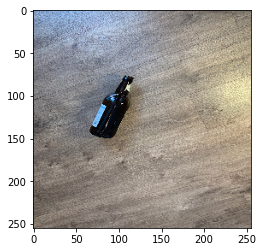

glass


In [ ]:
def visualize(img_path) 
  img = image.load_img(img_path, target_size=(255, 255))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255
  plt.imshow(img[0])
  plt.axis('on')
  plt.show()

  pred = np.argmax(model.predict(img))
  print(labels_1.get(str(pred)))

In [ ]:
#See live accuracy and tweak:
def test_live_accuracy(dataset):
  acc = 0
  i = 0
  incorrect = []
  for waste_type in os.listdir(dataset)[1:]:
    print('///////////////////////')
    print('///////////////////////')
    print('Now testing: ' + waste_type)
    print('///////////////////////')
    print('///////////////////////')
    for img in os.listdir('dataset/' + waste_type):
        i += 1
        img = image.load_img('dataset/' + waste_type + '/' + img, target_size=(255, 255))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img/255
        pred = np.argmax(model.predict(img))
        pred = labels_1.get(str(pred))
        if pred == waste_type:
          acc += 1
        else:
          x = waste_type + ' - ' + pred
          incorrect.append(x)
        print('Current Accuracy: ' + str(acc/i))

In [ ]:
%tensorboard --logdir logs